In [15]:
# Version 1
# 1..9
# Yes, No, Up, Down, Left, Right, On, Off, Stop, Go
# Backward, Forward, Follow, Learn
# Bed, Bird, Cat, Dog, Happy, House, Marvin, Sheila, Tree, Wow

#Make sure all of the libraries are installed using pip
import tensorflow as tf
import tensorflow_datasets as tfds
from datasets import load_dataset
import numpy as np
import librosa

def preprocess_audio(file_path, target_sr=16000, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=target_sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0) # Mean across time

file_path = "recordings/up/0a7c2a8d_nohash_0.wav"
mfccs = preprocess_audio(file_path)
print(f"MFCC shape: {mfccs.shape}")


MFCC shape: (32, 13)


Get file paths

In [57]:
import os
import glob
import pandas as pd
import numpy as np

dataset_path = "recordings/"

def preprocess_audio(file_path, target_sr=16000, feature_type='mel', n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=target_sr)

    if feature_type == 'mel':
        mel_spectogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        return librosa.amplitude_to_db(mel_spectogram, ref=np.max)
    elif feature_type == 'mfcc':
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0) # Mean across time
    else:
        raise ValueError("Invalid feature_type. Use 'mel' or 'mfcc'")

df = pd.DataFrame(columns=['Label', 'File_Path'])
X = []

selected_labels = ['up', 'down', 'left', 'right']
for label in selected_labels:
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        file_paths = glob.glob(os.path.join(label_path, "*.wav"))

        for file_path in file_paths:
            X.append(preprocess_audio(file_path, feature_type='mfcc'))
            new_row = {'Label': label, 'File_Path': file_path}
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df.head()

X = np.array(X)
y = df['Label'].values

Check for balance

In [ ]:
counts = df['Label'].value_counts()
print(counts)
df.info()
df.head()

Encoding labels using One-Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

encoded_data = encoder.fit_transform(df[['Label']])

print(encoded_data)
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Label']))

df = pd.concat([df, encoded_df], axis=1)

In [132]:
#Updating y
y = encoded_data

print("Feature Shape (X):", X.shape)
print("Label Shape (y):", y.shape)

Feature Shape (X): (9454, 13)
Label Shape (y): (9454, 4)


Display spectogram

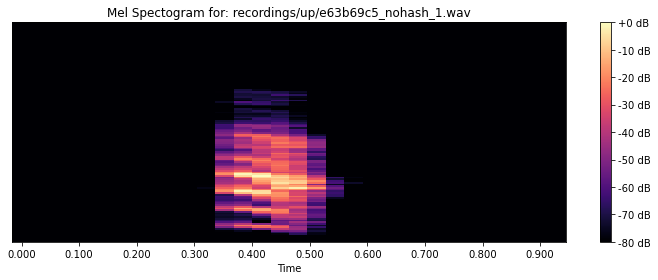

In [133]:
import matplotlib.pyplot as plt
import librosa.display

recording = df['File_Path'][0]

def display_spectogram(feature_matrix, feature_type='mel'):
    # Mel spectogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(feature_matrix, sr=16000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectogram for: {recording}")
    plt.tight_layout()
    plt.show()

mel_feature = preprocess_audio(recording)
display_spectogram(mel_feature)

Train Test Val Split

In [134]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (5672, 13)
Validation set size: (1891, 13)
Test set size: (1891, 13)


Normalization

In [135]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [144]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
histories = [] #Training history for each learning rate

n_labels = y.shape[1]

for lr in learning_rates:
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X.shape[1],)),  # Input layer
        #Number of neurons in last layer should match the number of unique labels
        Dense(n_labels, activation='softmax')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    histories.append((lr, history))

/home/foxide/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss curves plot

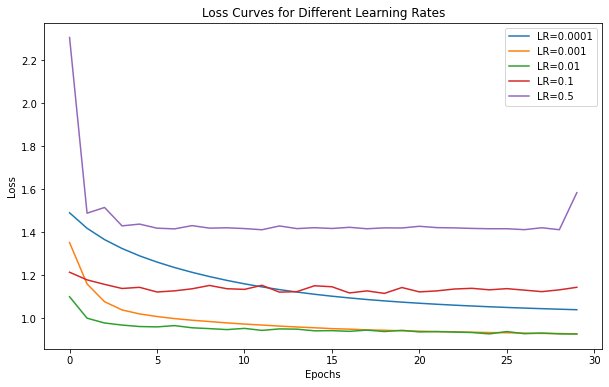

In [146]:
plt.figure(figsize=(10, 6))
for lr, history in histories:
    plt.plot(history.history['loss'], label=f"LR={lr}")

plt.title("Loss Curves for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Plotting training loss for gradient descent visualization

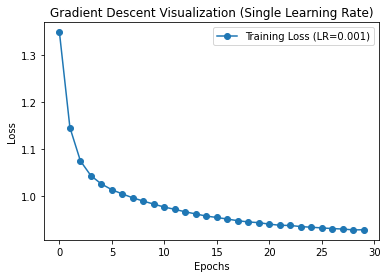

In [172]:
lr = 0.001
model = Sequential([
    Dense(32, activation='relu', input_shape=(X.shape[1],)),
    Dense(n_labels, activation='softmax')
])
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0)

plt.plot(history.history['loss'], marker='o', label=f"Training Loss (LR={lr})")
plt.title("Gradient Descent Visualization (Single Learning Rate)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Generate predictions
y_pred = model.predict(X_val)  # Predicted probabilities
y_pred_labels = np.argmax(y_pred, axis=1)  # Predicted class labels
y_true_labels = np.argmax(y_val, axis=1)  # True class labels

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Validation Accuracy: {accuracy: .2%}")

    
# Print predictions for the first 5 samples
print(f"{'Sample':<10} {'Predicted':<15} {'True':<10} {'Probabilities':<40}")
print("-" * 80)
for i in range(5):  # Display the first 5 samples
    print(
        f"{i:<10} {y_pred_labels[i]:<15} {y_true_labels[i]:<10} "
        f"{np.array2string(y_pred[i], precision=3, floatmode='fixed')}"
    )


print("Last 5 samples")
for i in range(-5, 0):  # Display the last 5 samples
    print(
        f"{i:<10} {y_pred_labels[i]:<15} {y_true_labels[i]:<10} "
        f"{np.array2string(y_pred[i], precision=3, floatmode='fixed')}"
    )

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
Validation Accuracy:  60.18%
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       443
           1       0.63      0.53      0.57       472
           2       0.59      0.64      0.62       490
           3       0.68      0.73      0.70       486

    accuracy                           0.60      1891
   macro avg       0.60      0.60      0.60      1891
weighted avg       0.60      0.60      0.60      1891

Sample     Predicted       True       Probabilities                           
--------------------------------------------------------------------------------
0          1               3          [0.341 0.414 0.044 0.201]
1          2               2          [0.189 0.175 0.418 0.218]
2          2               2          [4.728e-02 2.695e-01 6.828e-01 4.592e-04]
3          1               1          [0.012 0.974 0.008 0.006]
4          2               1          [0.233 0.179 0.349 0.239]

Per-Sample Loss

In [179]:
# Compute per-sample loss
losses = -np.log(y_pred[np.arange(len(y_pred)), y_true_labels])

# Add predictions, true labels, and losses to a DataFrame for analysis
import pandas as pd
results_df = pd.DataFrame({
    "Predicted": y_pred_labels,
    "True": y_true_labels,
    "Loss": losses,
    "Probabilities": [list(prob) for prob in y_pred]
})

# Sort by loss to find the most challenging samples
results_df_sorted = results_df.sort_values(by="Loss", ascending=False)
print(results_df_sorted.head(20))  # Display top 10 samples with highest loss


      Predicted  True      Loss  \
528           2     3  6.664994   
567           3     2  6.558943   
32            3     2  5.986557   
1354          1     3  5.681607   
205           3     1  5.591200   
1040          1     2  5.209770   
1154          1     3  5.139175   
819           3     0  4.842641   
388           3     2  4.689378   
352           3     2  4.611179   
1636          2     3  4.434878   
1024          3     0  4.317671   
442           2     3  4.316947   
517           1     0  4.315814   
113           1     0  4.158210   
1185          3     0  4.062570   
1343          1     2  4.028383   
789           3     0  3.880685   
383           1     3  3.850750   
1804          2     3  3.841196   

                                          Probabilities  
528   [0.06234048, 0.35297352, 0.5834113, 0.0012747643]  
567   [0.037557792, 0.29391697, 0.0014173831, 0.6671...  
32      [0.053892735, 0.06206381, 0.0025123, 0.8815311]  
1354   [0.16654117, 0.44378293, 

Play the '528' recording

In [188]:
from IPython.display import Audio

#Install audio-preview extension 

# Retrieve the file path for record 528
record_index = 5
file_path = df.loc[record_index, 'File_Path']
print(f"File Path for Record {record_index}: {file_path}")

Audio(file_path)

OSError: PortAudio library not found